In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

from import_fun import mLCE_delay_jit_discrete, compute_mle_discrete

In [2]:
lam = 1.3 # 特征值

# 模型常数
a = 0.89
b = 0.18  # 0.6 to 0.18 oscillations to aperiodic burst
c = 0.28
k = 0.03

T_init = int(5e4)
T_cal = int(1e6)
t0 = 0.

In [3]:
@njit
def f(x, x_tau, t, eps):
    res = np.zeros_like(x)

    res[0]= ((x[0]** 2) * np.exp(x[1] - x[0]) + k)*(1-eps) + eps*x_tau[0]
    res[1] = a * x[1] - b * x[0] + c

    return res

@njit
def jac(x, x_tau, t, eps):
    # f 相对于 x 的雅可比行列式。
    df_dx = np.zeros((x.shape[0], x.shape[0]))

    df_dx[0, 0] = ((2 * x[0]) * np.exp(x[1] - x[0]) - (x[0]** 2) * np.exp(x[1] - x[0]))*(1-eps)
    df_dx[0, 1] = ((x[0]** 2) * np.exp(x[1] - x[0]))*(1-eps)
    df_dx[1, 0], df_dx[1, 1] = -b, a

    
    # 耦合函数 H 相对于 x 的雅可比行列式。
    df_dx_tau = np.zeros((x.shape[0], x.shape[0]))
    df_dx_tau[0, 0] = eps/2 *(2 - lam)   # 1 --> 1
    
    return df_dx, df_dx_tau

In [4]:
# eps = 0.3  # 耦合强度
# tau = 12
x0 = np.random.rand(2)
# mle = mLCE_delay_jit_discrete(x0, f, jac, tau, T_init, T_cal, eps)
# mle = compute_mle_discrete(x0, f, jac, tau, T_init, T_cal, eps)

In [5]:
tau_list = [1, 3, 6, 9, 12]
eps_list = np.arange(0, 0.31, 0.01)

In [6]:
@njit(parallel=True)
def parallel_msf_mLCE(tau_list, eps_list, x0, f, jac, T_init, T_cal):
    n1 = len(tau_list)
    n2 = len(eps_list)
    mle = np.zeros((n1, n2))
    for j in prange(n2):
        eps = eps_list[j]
        for i in range(n1):
            tau = tau_list[i]
            mle[i, j] = compute_mle_discrete(x0, f, jac, tau, T_init, T_cal, eps)

    return mle

In [7]:
mles = parallel_msf_mLCE(tau_list, eps_list, x0, f, jac, T_init, T_cal)

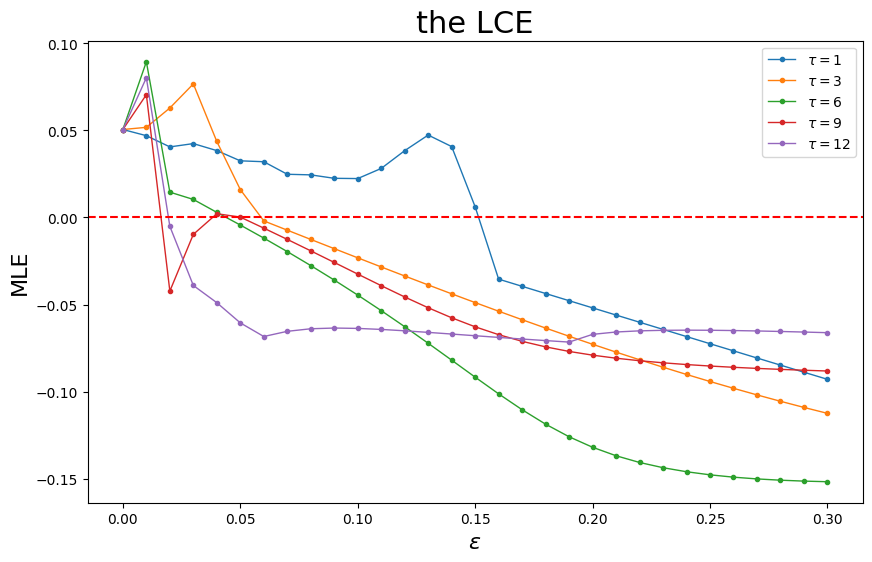

In [8]:
# %matplotlib widget
# Plot of LCE_list
plt.figure(figsize=(10, 6))
for i, tau in enumerate(tau_list): 
    plt.plot(eps_list[:mles.shape[1]], mles[i], '-o', markersize=3, linewidth=1, label=rf"$\tau={tau}$")    # , color="b"
plt.legend()
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel(r"$\varepsilon$ ", fontsize=16)
plt.ylabel("MLE", fontsize=16)
plt.title("the LCE", fontsize=22)
plt.show()